# A Global Data-driven High-resolution Weather Model: FourCastNet

## Overview

FourCastNet (Fourier ForeCasting Neural Network) is a data-driven global weather forecast model developed by researchers from NVIDIA, Lawrence Berkeley National Laboratory, University of Michigan Ann Arbor, and Rice University. It provides medium-term forecasts of key global weather indicators with a resolution of 0.25°. Equivalent to a spatial resolution of approximately 30 km x 30 km near the equator and a global grid of 720 x 1440 pixels in size. Compared with the traditional NWP model, this model improves the prediction speed by 45000 times, generates a week's weather forecast within 2 seconds, and achieves the prediction accuracy comparable to that of the most advanced numerical weather forecast model, ECMWF Integrated Forecast System (IFS). This is the first AI weather forecast model that can be directly compared to the IFS system.

This tutorial introduces the research background and technical path of FourCastNet, and shows how to train and fast infer the model through MindFlow. More information can be found in [paper] (https://arxiv.org/abs/2202.11214).

## Technology Path

MindEarth solves the problem as follows:

1. Model Construction.
2. Loss function.
3. Model Training.
4. Model Evaluation and Visualization.

## FourCastNet

In order to achieve high resolution prediction, FourCastNet uses AFNO model. The model network architecture is designed for high-resolution input, uses ViT as the backbone network, and incorporates Fourier Neural Operator (FNO) proposed by Zongyi Li et al. The model learns the mapping between function spaces so that series of nonlinear partial differential equations are solved.

The Vision Transformer (ViT) architecture and its variants have become the most advanced technology in computer vision over the past few years, exhibiting outstanding performance on many tasks. This performance is mainly attributed to the multi-head self-attention mechanism in the network, which makes the global modeling between each layer of features in the network. However, computation complexity of a model during training and inference increases quadratic as a quantity of tokens (or patches) increases, and model computation complexity increases explosively as input resolution increases.

The ingenuity of the AFNO model is that it converts the Spatial Mixing operation to the Fourier transform to mix the information of different tokens, transforms the features from the spatial domain to the frequency domain, and applies a globally learnable filter to the frequency domain features. The spatial mixing complexity is effectively reduced to O(NlogN), where N is the number of tokens.

The following figure shows the FourCastNet network architecture.

![AFNO model](images/AFNO.png)

Model training consists of three steps:

1. Pre-training: As shown in Figure (a) above, in the pre-training step, the AFNO model is trained in a supervised manner using the training dataset to learn the mapping from X(k) to X(k + 1).

2. Fine tuning: As shown in Figure (b) above, the model first predicts X(k + 1) from X(k) and then uses X(k + 1) as input to predict X(k + 2). Then, the model is optimized using the sum of the two loss function values by calculating the loss function values from the predicted values of X(k + 1) and X(k + 2).

3. Precipitation forecast: As shown in (c) above, the precipitation forecast is spliced by a separate model behind the backbone model. This method decouples the prediction task of precipitation from the basic meteorological factors. On the other hand, the trained precipitation model can also be used in combination with other prediction models (traditional NWP, etc.).

This tutorial mainly implements the model pre-training part.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from mindspore import context
from mindspore.train.serialization import load_checkpoint, load_param_into_net

[WARNING] ME(823:140375456403712,MainProcess):2023-08-21-07:34:37.107.933 [/data1/lbk/MindEarthtmp/applications/medium-range/fourcastnet/mindearth/__init__.py:59] Current version of MindSpore is not compatible with MindEarth. Some functions might not work or even raise error. Please install MindSpore version >= 1.8.1 For more details about dependency setting, please check the instructions at MindSpore official website https://www.mindspore.cn/install or check the README.md at https://gitee.com/mindspore/mindscience
[WARNING] ME(823:140375456403712,MainProcess):2023-08-21-07:34:37.109.156 [/data1/lbk/MindEarthtmp/applications/medium-range/fourcastnet/mindearth/__init__.py:67] Please pay attention to the above warning, countdown: 3
[WARNING] ME(823:140375456403712,MainProcess):2023-08-21-07:34:38.110.843 [/data1/lbk/MindEarthtmp/applications/medium-range/fourcastnet/mindearth/__init__.py:67] Please pay attention to the above warning, countdown: 2
[WARNING] ME(823:140375456403712,MainProc

In [ ]:
from mindearth.utils import load_yaml_config, create_logger, plt_global_field_data
from mindearth.module import Trainer
from mindearth.data import Dataset, Era5Data
from mindearth import RelativeRMSELoss
from mindearth.cell import AFNONet

from src.callback import EvaluateCallBack, InferenceModule

The following `src` can be downloaded in `MindEarth/applications/fourcastnet/src`.

In [2]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

In [3]:
config = load_yaml_config('FourCastNet.yaml')
logger = create_logger(path="results.log")

You can get parameters of model, data and optimizer from `config`.

## Model Construction

The model flow calculation process is as follows:

1. Divide data into h*w patches. The size of each patch is p (p=8). Each patch is regarded as a token.

2. Map each patch to a high-dimensional space, add spatial information, and transmit the information to the AFNO layer.

3. The AFNO layer consists of L layers. Each layer includes a spatial mixing module and a channel mixing module. The spatial mixing module is completed by a Fourier neural operator, and the Linear Dcoder outputs a prediction result.


In [4]:
data_params = config['data']
model_params = config['model']

model = AFNONet(image_size=(data_params['h_size'], data_params['w_size']),
                in_channels=data_params["feature_dims"],
                out_channels=data_params["feature_dims"],
                patch_size=data_params["patch_size"],
                encoder_depths=model_params["encoder_depths"],
                encoder_embed_dim=model_params["encoder_embed_dim"],
                mlp_ratio=model_params["mlp_ratio"],
                dropout_rate=model_params["dropout_rate"])

## Loss Function

FourCastNet uses relative root mean squared error for model training.

In [5]:
loss_fn = RelativeRMSELoss()

## Model Training

In this tutorial, we inherite the Trainer and override the _get_callback member function so that we can perform inference on the test dataset during the training process.

With MindSpore version >= 1.8.1, we can use the functional programming for training neural networks. MindEarth provide a training interface for model training.

In [6]:
class FCNTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super(FCNTrainer, self).__init__(config, model, loss_fn, logger)
        self.pred_cb = self._get_callback()

    def _get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb

trainer = FCNTrainer(config, model, loss_fn, logger)

2023-08-21 07:34:55,267 - pretrain.py[line:211] - INFO: steps_per_epoch: 404


[WARNING] ME(823:140375456403712,MainProcess):2023-08-21-07:34:56.317.523 [mindspore/train/model.py:1077] For EvaluateCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:35:27.192.061 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not parameter
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:35:27.192.109 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not parameter
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:35:27.192.280 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not parameter
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:35:

epoch: 1 step: 404, loss is 0.54113084
Train epoch time: 117981.554 ms, per step time: 292.034 ms
epoch: 2 step: 404, loss is 0.36134014
Train epoch time: 60664.333 ms, per step time: 150.159 ms
epoch: 3 step: 404, loss is 0.3416077
Train epoch time: 60319.328 ms, per step time: 149.305 ms
epoch: 4 step: 404, loss is 0.30162606
Train epoch time: 60762.650 ms, per step time: 150.403 ms
epoch: 5 step: 404, loss is 0.29819745
Train epoch time: 60783.895 ms, per step time: 150.455 ms
epoch: 6 step: 404, loss is 0.29213208
Train epoch time: 60516.691 ms, per step time: 149.794 ms
epoch: 7 step: 404, loss is 0.27456
Train epoch time: 60690.197 ms, per step time: 150.223 ms
epoch: 8 step: 404, loss is 0.2810102
Train epoch time: 60667.452 ms, per step time: 150.167 ms
epoch: 9 step: 404, loss is 0.27368036
Train epoch time: 60869.925 ms, per step time: 150.668 ms
epoch: 10 step: 404, loss is 0.26234776
Train epoch time: 60383.245 ms, per step time: 149.463 ms


2023-08-21 07:45:59,969 - forecast.py[line:209] - INFO: ================================Start Evaluation================================
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:46:22.608.292 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not parameter
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:46:22.608.342 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not parameter
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:46:22.609.323 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not parameter
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:46:22.609.351 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not param

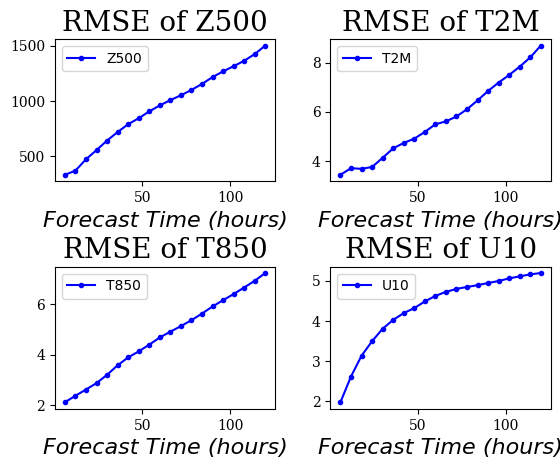

<Figure size 1400x700 with 0 Axes>

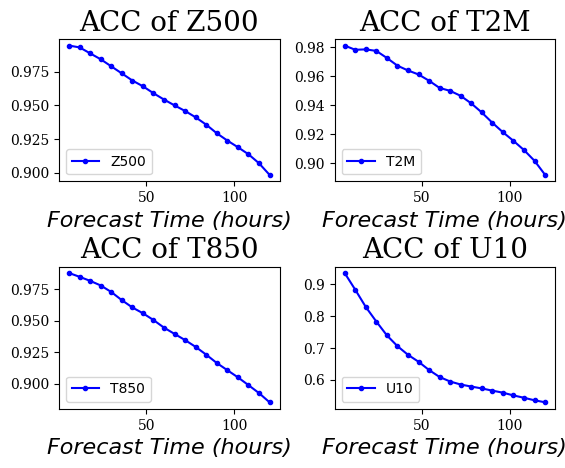

In [7]:
trainer.train()

## Model Evaluation and Visualization

In [8]:
pred_time_index = 0

params = load_checkpoint('./summary/ckpt/step_1/FourCastNet_2-10_404.ckpt')
load_param_into_net(model, params)
inference_module = InferenceModule(model, config, logger)

In [9]:
def plt_data(pred, label, root_dir, index=0):
    """ Visualize the forecast results """
    std = np.load(os.path.join(root_dir, 'statistic/std.npy'))
    mean = np.load(os.path.join(root_dir, 'statistic/mean.npy'))
    std_s = np.load(os.path.join(root_dir, 'statistic/std_s.npy'))
    mean_s = np.load(os.path.join(root_dir, 'statistic/mean_s.npy'))
    pred, label = pred[index].asnumpy(), label.asnumpy()[..., index, :, :]
    plt.figure(num='e_imshow', figsize=(100, 50), dpi=100)

    plt.subplot(4, 3, 1)
    plt_global_field_data(label, 'Z500', std, mean, 'Ground Truth')  # Z500
    plt.subplot(4, 3, 2)
    plt_global_field_data(pred, 'Z500', std, mean, 'Pred')  # Z500
    plt.subplot(4, 3, 3)
    plt_global_field_data(label - pred, 'Z500', std, mean, 'Error')  # Z500

    plt.subplot(4, 3, 4)
    plt_global_field_data(label, 'T850', std, mean, 'Ground Truth')  # T850
    plt.subplot(4, 3, 5)
    plt_global_field_data(pred, 'T850', std, mean, 'Pred')  # T850
    plt.subplot(4, 3, 6)
    plt_global_field_data(label - pred, 'T850', std, mean, 'Error')  # T850

    plt.subplot(4, 3, 7)
    plt_global_field_data(label, 'U10', std_s, mean_s,
                          'Ground Truth', is_surface=True)  # U10
    plt.subplot(4, 3, 8)
    plt_global_field_data(pred, 'U10', std_s, mean_s,
                          'Pred', is_surface=True)  # U10
    plt.subplot(4, 3, 9)
    plt_global_field_data(label - pred, 'U10', std_s,
                          mean_s, 'Error', is_surface=True)  # U10

    plt.subplot(4, 3, 10)
    plt_global_field_data(label, 'T2M', std_s, mean_s,
                          'Ground Truth', is_surface=True)  # T2M
    plt.subplot(4, 3, 11)
    plt_global_field_data(pred, 'T2M', std_s, mean_s,
                          'Pred', is_surface=True)  # T2M
    plt.subplot(4, 3, 12)
    plt_global_field_data(label - pred, 'T2M', std_s,
                          mean_s, 'Error', is_surface=True)  # T2M

    plt.savefig(f'pred_result.png', bbox_inches='tight')
    plt.show()


[WARNING] MD(823,7fabb536d100,python):2023-08-21-07:50:40.572.654 [mindspore/ccsrc/minddata/dataset/util/task.cc:163] Join] GeneratorOp(ID:2) Thread ID 140367936595712 is not responding. Interrupt again
[WARNING] MD(823,7fabb536d100,python):2023-08-21-07:50:41.572.852 [mindspore/ccsrc/minddata/dataset/util/task.cc:163] Join] GeneratorOp(ID:2) Thread ID 140367936595712 is not responding. Interrupt again
[WARNING] MD(823,7fabb536d100,python):2023-08-21-07:50:42.572.996 [mindspore/ccsrc/minddata/dataset/util/task.cc:163] Join] GeneratorOp(ID:2) Thread ID 140367936595712 is not responding. Interrupt again
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:50:56.685.129 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefOutput] ref op origin node is not parameter
[WARNING] PRE_ACT(823,7fabb536d100,python):2023-08-21-07:50:56.685.183 [mindspore/ccsrc/plugin/device/ascend/optimizer/format_type/deal_ref_output.cc:109] AddAdditionalToRefO

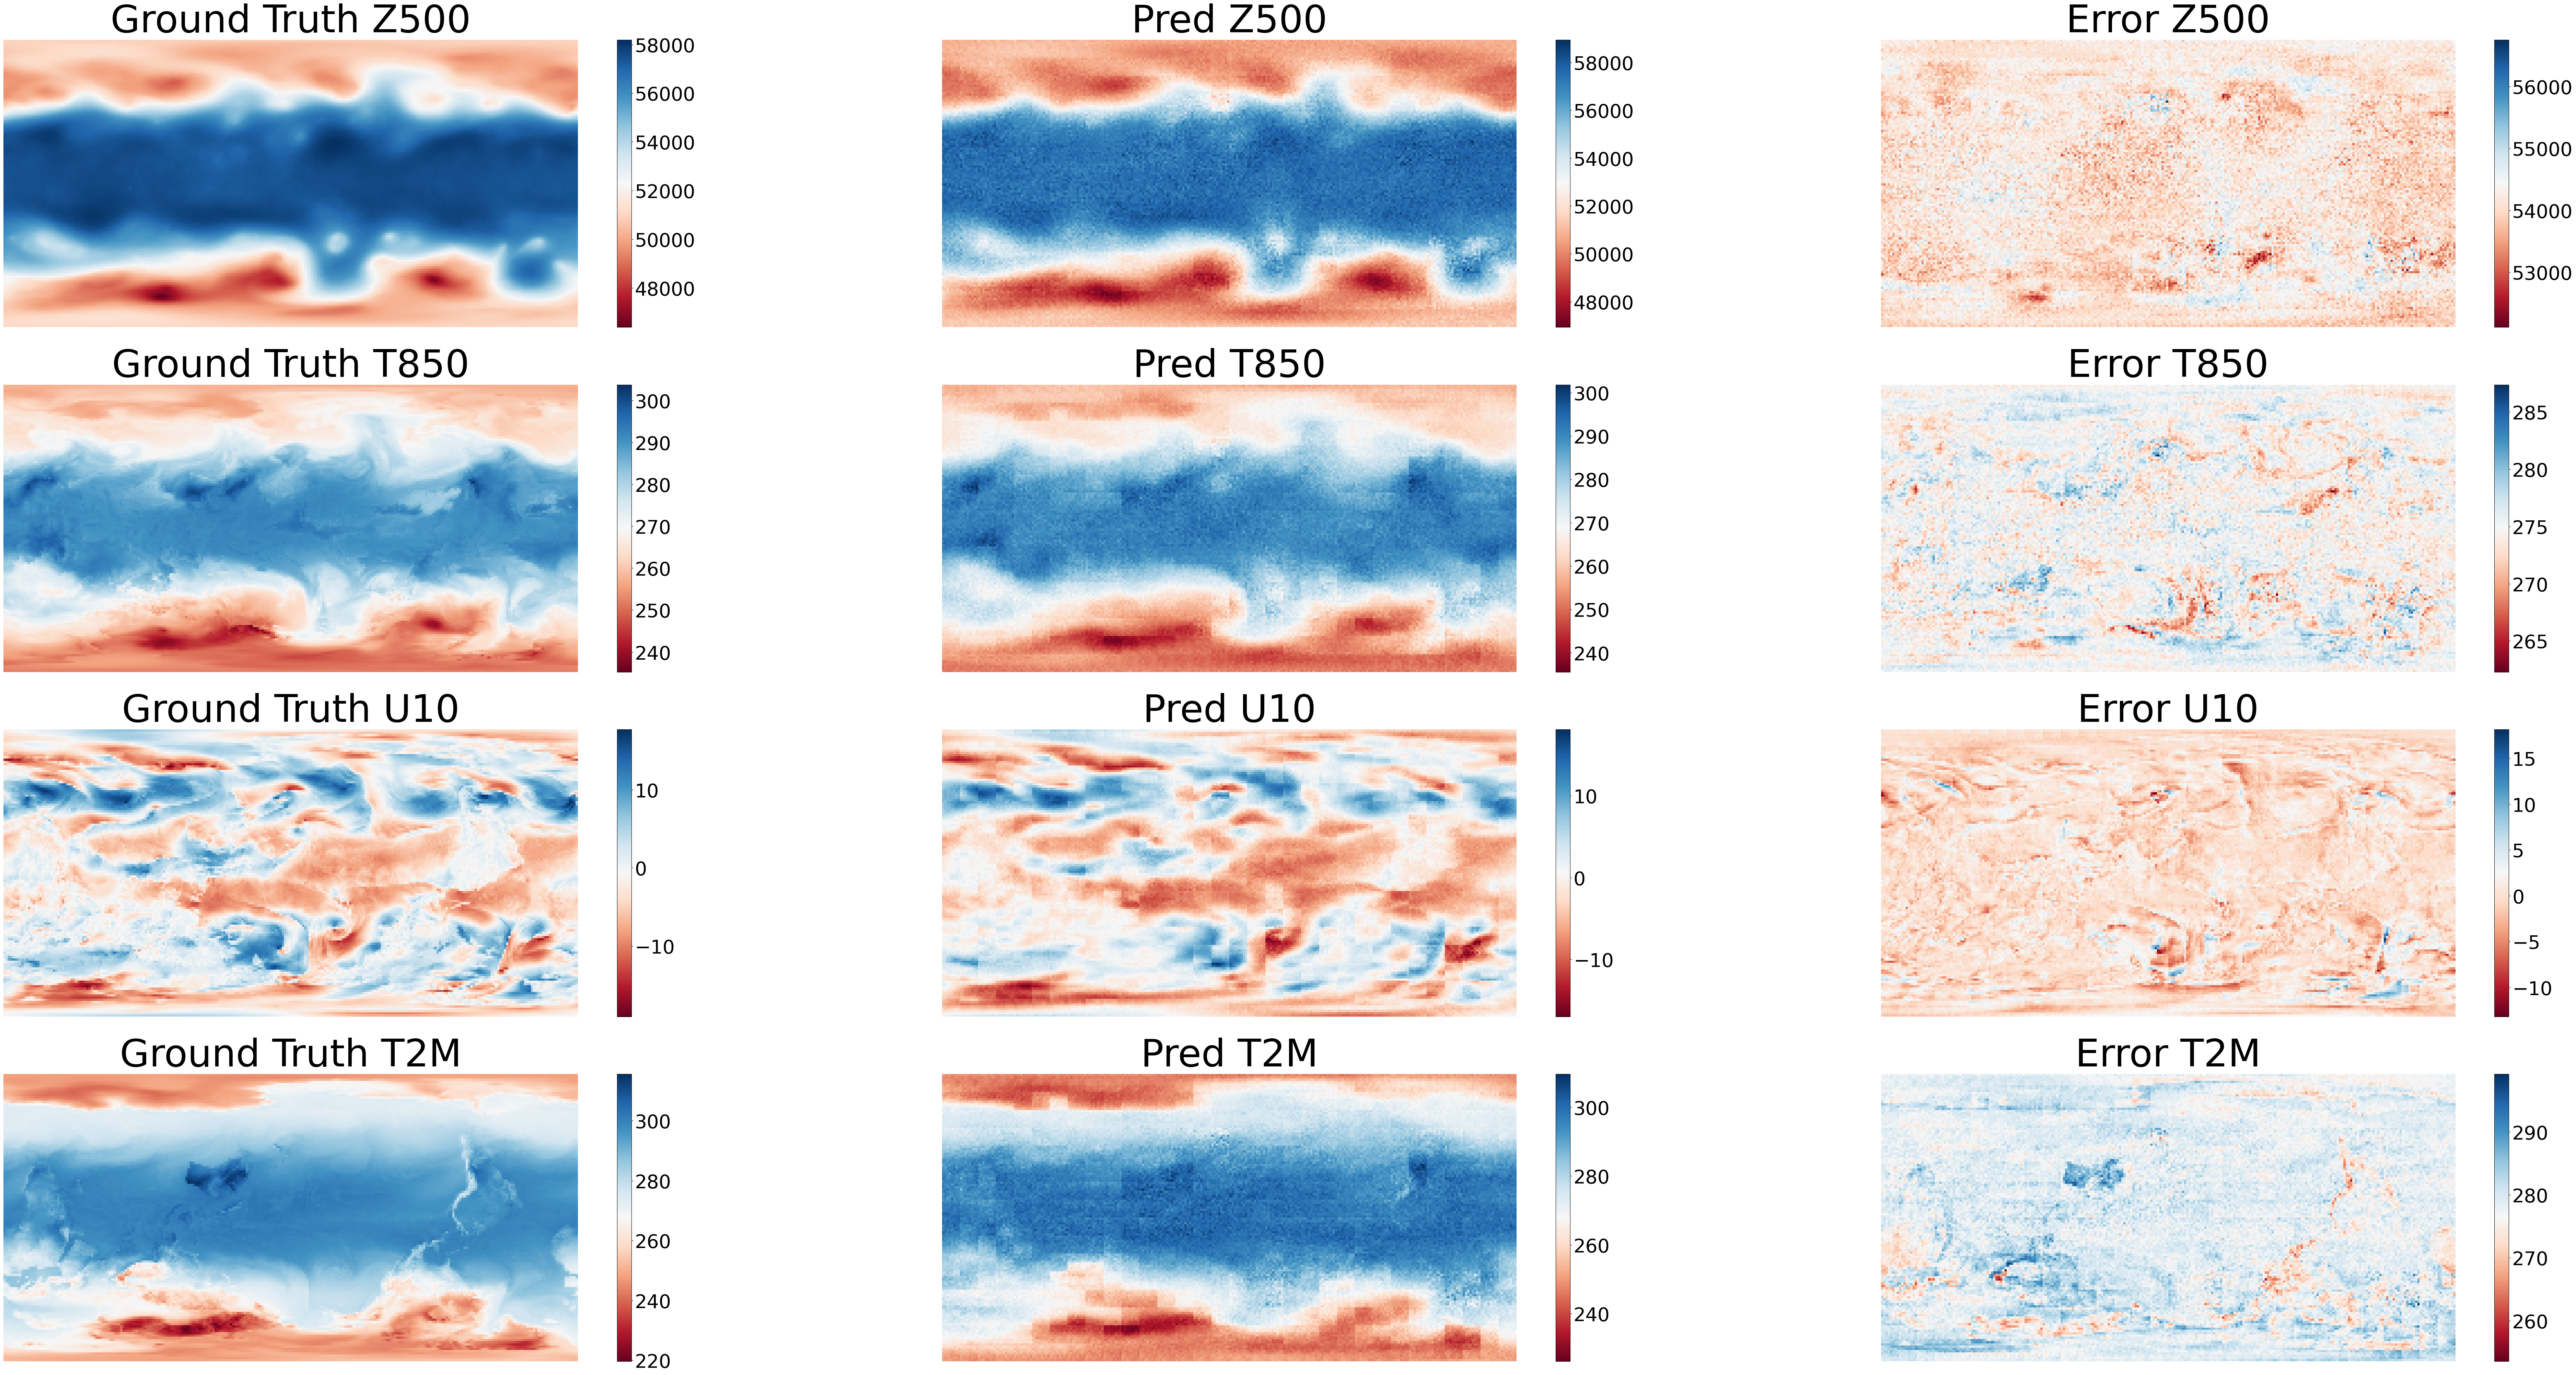

In [10]:

test_dataset_generator = Era5Data(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']
pred = inference_module.forecast(inputs)
plt_data(pred, labels, config['data']['root_dir'])